import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import random

2023-06-12 10:41:38.426862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 10:41:38.552256: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 10:41:38.553256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 10:41:39.482242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


functions

In [2]:
def plot(accuracy, loss, val_accuracy, val_loss): # return schedule of accuracy and loss
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('total loss')
    ax1.plot(loss, color='tab:red', label='Training Loss')
    ax1.plot(val_loss, color='tab:brown', label='Validation Loss')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()
    ax2.set_ylabel('accuracy')
    ax2.plot(accuracy, color='tab:blue', label='Training Accuracy')
    ax2.plot(val_accuracy, color='tab:green', label='Validation Accuracy')
    ax2.tick_params(axis='y')

    # Combine the legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc='lower right')

    # Set the title
    plt.title('Графік залежностей точності та втрат від кількості Епох')

    fig.tight_layout()
    plt.show()


In [3]:
def get_image_and_transform(path, dims=False, mode='grayscale'):
    
    data = utils.load_img(path, color_mode=mode, target_size=(64,64))
    data = np.array(data)
    if dims:
        data = np.expand_dims(data, axis=0)
    data = data / 255.0
    return data

In [3]:
def contrastive_loss(y, preds, margin=0.01):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)
	# calculate the contrastive loss between the true labels and the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
	# return the computed contrastive loss to the calling function
	return loss

![F](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/01/contrastive_loss_keras_constrastive_loss_function_updated.png?lossy=1&strip=1&webp=1)

In [5]:
# def build_dataset(dataset_dir, label, dims=False, mode='grayscale'): # build 2 list with array for training and 1 list with labels
#     x_train1, x_train2, y_train = [], [], []
#     classes = sorted(os.listdir(dataset_dir))
#     for i in range(len(classes)):
#         class_dir = os.path.join(dataset_dir, classes[i])
#         images = os.listdir(class_dir)
#         if len(images) == 1:
#             continue
#         if len(images) % 2 != 0:
#             del images[len(images) - 1]
#         for image in range(len(images)):
#             full_image_path = os.path.join(class_dir, images[image])
#             if 'ipynb_checkpoints' in full_image_path:
#                 continue
#             if image < len(images)//2:
#                 y_train.append(label)
#                 x_train1.append(get_image_and_transform(full_image_path, dims, mode))
#             else:
#                 x_train2.append(get_image_and_transform(full_image_path, dims, mode))
#     return x_train1, x_train2, y_train

dataset

In [6]:
# train_data = "/home/jovyan/dataset1/dataset2/train"
# # train_wrong_data = "/home/jovyan/dataset1/dataset2/test"

# train_data_1, train_data_2, train_labels1 = build_dataset(train_data, 1)
# # train_data_3, train_data_4, train_labels2 = build_dataset(train_wrong_data, 0)

# # random.shuffle(train_data_3)
# # random.shuffle(train_data_4)

# # train_data_1 = train_data_1 + train_data_3
# # train_data_2 = train_data_2 + train_data_4
# # train_labels1 = train_labels1 + train_labels2

# train_data_1 = np.array(train_data_1)
# train_data_2 = np.array(train_data_2)
# train_labels1 = np.array(train_labels1)

# print(
#     len(train_data_1),
#     len(train_data_2),
#     len(train_labels1)
#     )

In [3]:
def build_siamese_dataset(train_folder, mode='grayscale'):
    """ Function for creating siamese neural network model
    
    Parameters:
    train_folder (str): path to folder with images
    mode (str): determines color mode: rgb or grayscale 

    Returns:
    x_train1 (list): train data
    x_train2 (list): train data
    """
    train_datagen = ImageDataGenerator(rescale=1./255) 
    training_set = train_datagen.flow_from_directory(train_folder,
                                                     target_size=(64,64),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     color_mode=mode,
                                                     shuffle=True,
                                                     seed=42,
                                                     subset='training')
    x_train1, x_train2 = [], []
    for i in range(len(training_set)):
        images, labels = training_set[i]
        images, labels = images[len(images)//2+5:], labels[len(labels)//2+5:]
        num = len(images) -1 if len(images) % 2 != 0 else len(images)
        for o in range(num):
            if o % 2 == 0:
                x_train1.append(images[o])
            else:
                x_train2.append(images[o])
    return x_train1, x_train2


In [4]:
x_train1, x_train2 = build_siamese_dataset("/home/jovyan/dataset1/dataset2/train", 'rgb')
x_train1 = x_train1[:len(x_train1)//2]
x_train2 = x_train2[:len(x_train2)//2]

x_train2 = x_train2[:len(x_train2)+1] + x_train2[:len(x_train2):-1]
train_labels1 = [1] * (len(x_train2)//2) + [0] * (len(x_train2)//2) + [0]

x_train1 = np.array(x_train1)
x_train2 = np.array(x_train2)
train_labels1 = np.array(train_labels1)
# train_labels1 = train_labels1[:len(train_labels1)-1]


Found 22736 images belonging to 164 classes.


In [5]:
x_test1, x_test2 = build_siamese_dataset("/home/jovyan/dataset1/dataset2/test", 'rgb')
x_test1 = x_test1[:len(x_test1)//2]
x_test2 = x_test2[:len(x_test2)//2]

x_test2 = x_test2[:len(x_test2)+1] + x_test2[:len(x_test2):-1]
test_labels1 = [1] * (len(x_test2)//2) + [0] * (len(x_test2)//2) + [0]

x_test1 = np.array(x_test1)
x_test2 = np.array(x_test2)
test_labels1 = np.array(test_labels1)
# test_labels1 = test_labels1[:len(test_labels1)-1]

Found 5684 images belonging to 164 classes.


# first implementation of siamese CNN

In [8]:
def siamese_model(in_1=32, in_2=32, in_3=32, in_4=64):
    """ Function for creating siamese neural network model
    
    Parameters:
    in_1 (int): filters amount
    in_2 (int): filters amount
    in_3 (int): filters amount
    in_4 (int): filters amount
    
    Returns:
    model (model): neural network model
    """
    input_shape = (64,64, 1)
    
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    shared_layers = [
        Conv2D(filters=in_1, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=in_2, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=in_3, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Conv2D(filters=in_4, kernel_size=3, strides=1, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        Flatten(),
        Dropout(0.1)
    ]
    
    fc_layers = [
        Dense(units=512, activation='tanh'),
        Dense(units=1, activation='sigmoid')
    ]
    
    output_1 = input_1
    output_2 = input_2
    for layer in shared_layers:
        output_1 = layer(output_1)
        output_2 = layer(output_2)
    
    concatenated = tf.keras.layers.Concatenate()([output_1, output_2])
    for layer in fc_layers:
        concatenated = layer(concatenated)
    
    siamese_model = Model(inputs=[input_1, input_2], outputs=concatenated)
    siamese_model.compile(optimizer=Adam(), loss=contrastive_loss, metrics=['accuracy'])
    
    return siamese_model
model1 = siamese_model()
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d[0][0]',             

In [ ]:
history = model1.fit([x_train1, x_train2],
                     train_labels1,
                     steps_per_epoch = 180,
                     epochs=15,
                     validation_data = ([x_test1,x_test2], test_labels1),
                     validation_steps=60,
                     shuffle=True)

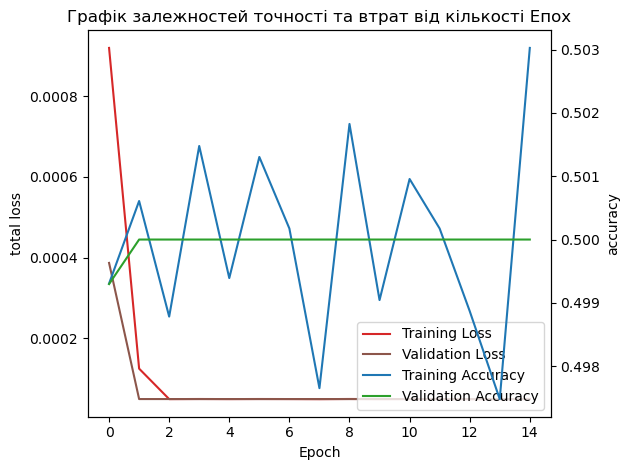

In [10]:
plot(history.history['accuracy'], history.history['loss'],history.history['val_accuracy'],history.history['val_loss'])

In [ ]:
def predict_siamese_model(siamese_model, data_1, data_2):
    predictions = siamese_model.predict([data_1, data_2])
    return predictions, float(predictions) > 0.5

img1 = get_image_and_transform('/home/jovyan/21.jpg', True)
img2 = get_image_and_transform('/home/jovyan/11.jpg', True)

predict_siamese_model(model1,img1, img2)

# second implementation of siamese CNN


In [6]:
def siamese_model2(in_1=32, in_2=32, in_3=32, in_4=64):
    """ Function for creating siamese neural network model
    
    Parameters:
    in_1 (int): filters amount
    in_2 (int): filters amount
    in_3 (int): filters amount
    in_4 (int): filters amount
    
    Returns:
    model (model): neural network model
    """
    input_shape = (64,64, 3)
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    base_model = tf.keras.applications.MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape)
    
    fc_layers = [
        Dense(units=512, activation='tanh'),
        Dense(units=1, activation='sigmoid')
    ]
    
    
    output_1 = base_model(input_1)
    output_2 = base_model(input_2)
    
    flattened_1 = Flatten()(output_1)
    flattened_2 = Flatten()(output_2)
    
    concatenated = tf.keras.layers.Concatenate()([flattened_1, flattened_2])
    for layer in fc_layers:
        concatenated = layer(concatenated)
    
    siamese_model = Model(inputs=[input_1, input_2], outputs=concatenated)
    siamese_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return siamese_model

model2 = siamese_model2()
model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 MobilenetV3small (Functional)  (None, 2, 2, 576)    939120      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 2304)         0           ['MobilenetV3small[0][0]']   

2023-06-12 10:42:02.703187: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.
2023-06-12 10:42:02.707296: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.
2023-06-12 10:42:02.710063: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.


In [ ]:
history = model2.fit([x_train1, x_train2],
                     train_labels1,
                     steps_per_epoch = 32,
                     epochs=60,
                     validation_data = ([x_test1,x_test2], test_labels1),
                     validation_steps=30,
                     shuffle=True)

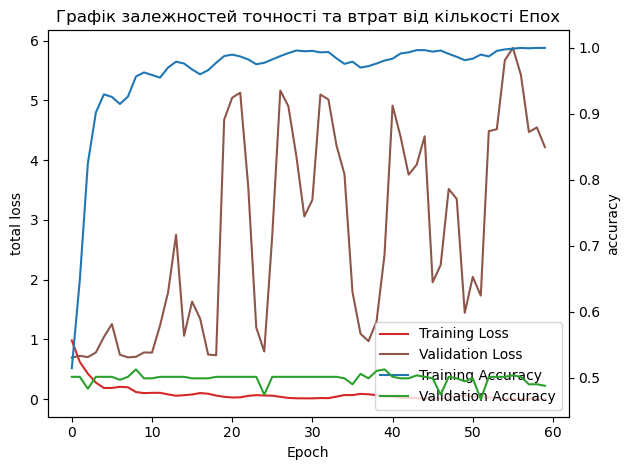

In [8]:
plot(history.history['accuracy'], history.history['loss'],history.history['val_accuracy'],history.history['val_loss'])

In [ ]:
def predict_siamese_model(siamese_model, data_1, data_2):
    predictions = siamese_model.predict([data_1, data_2])
    return predictions, float(predictions) > 0.5

img1 = get_image_and_transform('/home/jovyan/11.jpg', True, 'rgb')
img2 = get_image_and_transform('/home/jovyan/22.jpg', True, 'rgb')

predict_siamese_model(model2,img1, img2)